In [1]:
import jax.numpy as np
# from jax.config import config; config.update("jax_enable_x64", True)

import numpy as onp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.io.fits as pf
import xara
import xaosim as xs
from xaosim.pupil import PHARO

import morphine

import astropy.io.fits as fits

from tqdm import tqdm

import pickle, gzip

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")

import os

In [2]:
# ddir = os.path.abspath(os.path.dirname("__file__"))
ddir = '/Users/benjaminpope/code/xara/xara/'
# -------------------------------
# 1. create the KP info structure
# -------------------------------

# once saved, the kpi.gz structure can be directly reloaded when 
# creating a KPO instance, such as done in step #2.

a = xara.KPI(ddir+"hst.txt")
a.name = "HST - NIC1" #  # add a label to the template
a.save_to_file('./hst.kpi.gz')


Attempting to load file /Users/benjaminpope/code/xara/xara/hst.txt
332 distinct baselines were identified
10 first singular values for this array:
[46.79691 46.33162 35.01308 34.70472 20.0892  19.939   16.52361 16.40732
 13.82746 13.76126]

        Summary of properties for hst.txt
        ---------------------------------------------------------------
        - 112 sub-apertures
        - 332 distinct baselines
        - 276 Ker-phases (83.1 % target phase information recovery)
        -  56 Eig-phases (50.0 % wavefront information recovery)
        ---------------------------------------------------------------
        
KPI data successfully loaded


0

In [3]:
ls ../data/

n8yj25010/ n8yj25020/ n8yj56010/ n8yj56020/


In [4]:
fits.getheader('../data/n8yj25010/n8yj25010_mos.fits.gz')

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    0 / Number of axes                                 
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '2010-11-24T18:38:30' / Time of last modification                     
NEXTEND =                    5 / Number of standard extensions                  
DATE    = '2010-11-24T18:38:30' / date this file was written (yyyy-mm-dd)       
FILENAME= 'n8yj25010_mos.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'NICMOS'          

In [5]:
# -------------------
# 2. load the dataset
# -------------------

# load the FITS frame, and extract the Kernel-phases using the
# HST KPI template calculated at the previous step. 
# Two data sets are provided:
# n8yj59010_mos.fits.gz and 'n8yj59020_mos.fits.gz

band = 'J'
if band == 'J':
    fname_a = "../data/n8yj25010/n8yj25010_mos.fits.gz" # pope 2013 - binary? - J band - 2351
    fname_b = "../data/n8yj56010/n8yj56010_mos.fits.gz" # pope 2013 - calibrator - J band
    fname_kerphi = 'hstmorphine_32bit_64pix_J.kpi.gz'

elif band == 'H':
    fname_a = "../data/n8yj25020/n8yj25020_mos.fits.gz" # pope 2013 - binary? - H band
    fname_b = "../data/n8yj56020/n8yj56020_mos.fits.gz" # pope 2013 - calibrator - H band
    fname_kerphi = 'hstmorphine_32bit_128pix.kpi.gz'
# fname = ddir+'/n8yj59010_mos.fits.gz' # frantz example

# fname_kerphi = './hst.kpi.gz'
a = xara.KPO(fname_kerphi,offset=0.5)
b = a.copy()#xara.KPO(fname_kerphi,offset=0.5)
c = xara.KPO('./hst.kpi.gz')
a.extract_KPD(fname_a, wrad=50) # binary
b.extract_KPD(fname_b, wrad=50) # calibrator
c.extract_KPD(fname_b, wrad=50) # calibrator

a.kpi.name = "2M XXXX-XX" #  # labels the data


Attempting to load file hstmorphine_32bit_64pix_J.kpi.gz
KPI data successfully loaded
File provided is not a fits file
Attempting to load file ./hst.kpi.gz
KPI data successfully loaded
File provided is not a fits file
The data comes from HST
1 data fits files will be opened
First time for m2pix = 15.68: 
LDFT1: Computing new Fourier matrix...
Done!
File ../data/n8yj25010/n8yj25010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
First time for m2pix = 15.68: 
LDFT1: Computing new Fourier matrix...
Done!
File ../data/n8yj56010/n8yj56010_mos.fits.gz, slice  1
The data comes from HST
1 data fits files will be opened
First time for m2pix = 15.68: 
LDFT1: Computing new Fourier matrix...
Done!
File ../data/n8yj56010/n8yj56010_mos.fits.gz, slice  1


In [6]:
mydata = a.KPDT[0][0]-b.KPDT[0][0]
myerr = np.ones_like(mydata)*0.1*(onp.nanmedian(np.abs(mydata)))

In [7]:
a.PSCALE

43.1

In [8]:
test = fits.open(fname_a)


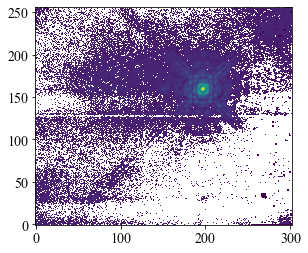

In [9]:
plt.imshow(test[1].data**0.25)

In [105]:
# fits.getheader("../data/n8yj56020/n8yj56020_mos.fits.gz")

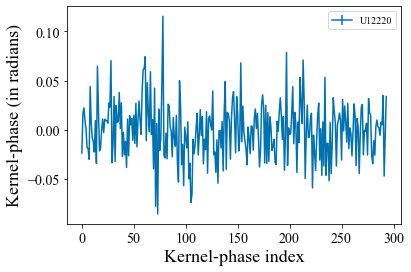

In [11]:
a.plot_KPD()


computing colinearity map...
max colinearity found for sep = 158.11 mas and ang = -34.70 deg


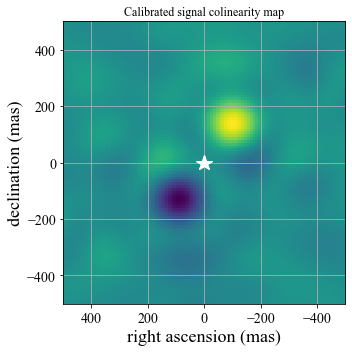

In [12]:
print("\ncomputing colinearity map...")
gsize = 100 # gsize x gsize grid
gstep = 10 # grid step in mas
xx, yy = np.meshgrid(
        np.arange(gsize) - gsize/2, np.arange(gsize) - gsize/2)
azim = -np.arctan2(xx, yy) * 180.0 / np.pi
dist = np.hypot(xx, yy) * gstep

#mmap = kpo1.kpd_binary_match_map(100, 10, mydata/myerr, norm=True)
mmap = a.kpd_binary_match_map(100, 10, mydata, norm=True)
x0, y0 = np.argmax(mmap) % gsize, np.argmax(mmap) // gsize
print("max colinearity found for sep = %.2f mas and ang = %.2f deg" % (
        dist[y0, x0], azim[y0, x0]))

f1 = plt.figure(figsize=(5,5))
ax1 = f1.add_subplot(111)
ax1.imshow(mmap, extent=(
        gsize/2*gstep, -gsize/2*gstep, -gsize/2*gstep, gsize/2*gstep))
ax1.set_xlabel("right ascension (mas)")
ax1.set_ylabel("declination (mas)")
ax1.plot([0,0], [0,0], "w*", ms=16)
ax1.set_title("Calibrated signal colinearity map")
ax1.grid()
f1.set_tight_layout(True)
f1.canvas.draw()


In [13]:
from scipy.optimize import leastsq

def binary_model(params,kpo):
    u = kpo.kpi.UVC[:,0]
    v = kpo.kpi.UVC[:,1]
    wl = kpo.CWAVEL
    detpa = 0
    return(xara.core.cvis_binary(u,v,wl, params, detpa))


def ben_binary_model_fit_residuals(params,kpo=a,index=0,obs="KERNEL"):
    temp = binary_model(params,kpo)
    model = kpo.kpi.KPM.dot(np.angle(temp))
    error = mydata-model
    error /= (myerr)
    return onp.array(error) 


def ben_binary_model_fit(p0,kpo=a,index=0,obs='KERNEL'):
    soluce = leastsq(ben_binary_model_fit_residuals, 
                 p0, args=((kpo,index, obs,)), full_output=1)

    return soluce



binary model fitting...
sep = 71.033177, ang=332.849335, con=1.517169 => chi2 = 7.732
correlation matrix of parameters
[[ 0.18 -0.03 -0.01]
 [-0.03  0.02  0.  ]
 [-0.01  0.    0.  ]]


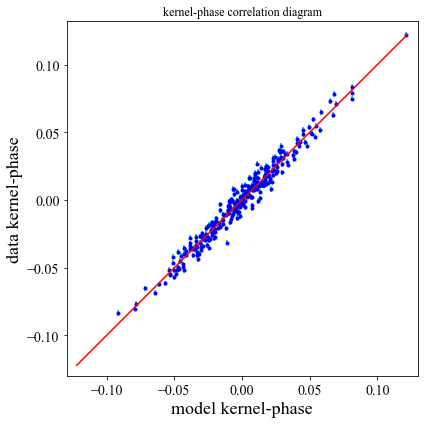

In [14]:
print("\nbinary model fitting...")
# p0 = params0 # good starting point
p0 =  [dist[y0, x0], azim[y0, x0], mmap.max()] # good starting point
p0[1] = np.mod(p0[1],360.)

wl = a.CWAVEL

# mfit = a.binary_model_fit(p0)
mfit = ben_binary_model_fit(p0,kpo=a)


p1 = mfit[0] # the best fit parameter vector (sep, P.A., contrast)
p1[1] = np.mod(p1[1],360.)
# p1 = p0


cvis_b = xara.core.cvis_binary(
        a.kpi.UVC[:,0], a.kpi.UVC[:,1], wl, p1) # binary
ker_theo = a.kpi.KPM.dot(np.angle(cvis_b))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.errorbar(ker_theo, mydata, yerr=myerr, fmt="none", ecolor='c')
ax.plot(ker_theo, mydata, 'b.')
mmax = (np.abs(mydata).max())
ax.plot([-mmax,mmax],[-mmax,mmax], 'r')
ax.set_ylabel("data kernel-phase")
ax.set_xlabel("model kernel-phase")
ax.set_title('kernel-phase correlation diagram')
ax.axis("equal")
# ax.axis([-11, 11, -11, 11])
fig.set_tight_layout(True)

if myerr is not None:
        chi2 = np.sum(((mydata - ker_theo)/myerr)**2) / a.kpi.nbkp
else:
        chi2 = np.sum(((mydata - ker_theo))**2) / a.kpi.nbkp

print("sep = %3f, ang=%3f, con=%3f => chi2 = %.3f" % (p1[0], p1[1], p1[2], chi2))
print("correlation matrix of parameters")
print(np.round(mfit[1], 2))


In [15]:
# sep = 139.775821, ang=349.202942, con=2.042950 => chi2 = 1.486 - 128 pix kernel phases
# sep = 140.641409, ang=349.074219, con=2.075557 => chi2 = 3.817 - Martinache model (slightly worse fit overall I think!)

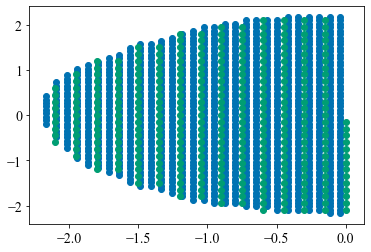

In [16]:
plt.scatter(a.kpi.UVC[:,0],a.kpi.UVC[:,1])
plt.scatter(c.kpi.UVC[:,0],c.kpi.UVC[:,1])

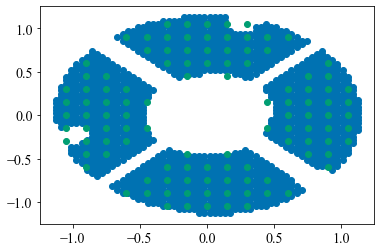

In [17]:
plt.scatter(a.kpi.VAC[:,0],a.kpi.VAC[:,1])
plt.scatter(c.kpi.VAC[:,0],c.kpi.VAC[:,1])

In [18]:
baselines = np.hypot(b.kpi.UVC[:,0],b.kpi.UVC[:,1])

In [389]:
otf = np.abs(b.CVIS[0][0])
otf_frantz = np.abs(c.CVIS[0][0])

(250, 350)

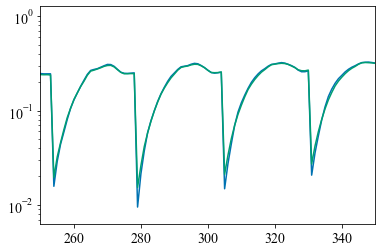

In [89]:
plt.plot(b.kpi.RED/b.kpi.RED.max(),'-')
plt.plot(otf/otf.max(),'-')
plt.yscale('log')
# plt.xlim(500,600)
plt.xlim(250,350)

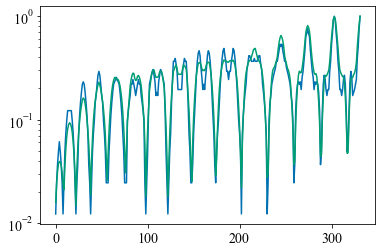

In [21]:
plt.plot(c.kpi.RED/c.kpi.RED.max(),'-')
plt.plot(otf_frantz/otf_frantz.max(),'-')
plt.yscale('log')

### now let's optimize this

In [299]:
from jax.scipy.ndimage import rotate
from jax.ops import index_update

def half_bin(array):
    return (array[::2,::2] + array[1::2,::2] + array[::2,1::2] + array[1::2,1::2])/4.



# ======================================================================
def HST_NIC1(params, PSZ, oversample=4, between_pix=True):
    ''' ---------------------------------------------------------
    returns an array that draws the pupil of HST/NICMOS1 camera

    Parameters:
    ----------
    - PSZ:     size of the array (assumed to be square)
    - rad:     radius of the standard pupil (in pixels)
    - between_pix: flag
    - ang:     global rotation of the pupil (in degrees)
    --------------------------------------------------------- '''
    PPSZ = PSZ*2
    thisPSZ = (PSZ*2)*(2**oversample)
    rad = (2**oversample)*PSZ/2
    
    xx,yy  = np.meshgrid(np.arange(thisPSZ)-thisPSZ/2, np.arange(thisPSZ)-thisPSZ/2)
    obstruction,spiders,m1,m2,m3,rout,rin,bigspiders,cpadr,ppad,pad_theta1,pad_theta2,shift,ang = params

    if between_pix is True:
        xx += 0.5
        yy += 0.5

    mydist = np.hypot(yy,xx)

    NCM = np.zeros_like(mydist) # nicmos cold mask

    # --------------------------------
    # OTA: Optical Telescope Assembly
    # --------------------------------
    OTA = np.zeros_like(mydist)
    OTA = index_update(OTA,mydist <= 1.000 * rad, 1.0) # outer radius
    OTA = index_update(OTA,mydist <= obstruction * rad, 0.0) # telescope obstruction
    OTA = index_update(OTA,np.abs(xx) < spiders * rad, 0.0) # spiders
    OTA = index_update(OTA,np.abs(yy) < spiders * rad, 0.0) # spiders

    tmp = np.roll(mydist, int(m1 * rad), axis=1) 
    OTA = index_update(OTA,tmp <= cpadr * rad, 0.0) # mirror pad

    tmp = np.roll(
        np.roll(mydist, int(m2[0] * rad), axis=0),
        int(m2[1] * rad), axis=1) 
    OTA = index_update(OTA,tmp <= cpadr * rad, 0.0) # mirror pad

    tmp = np.roll(
        np.roll(mydist, int(m3[0] * rad), axis=0),
        int(m3[1] * rad), axis=1) 
    OTA = index_update(OTA,tmp <= cpadr * rad, 0.0) # mirror pad

    # --------------------------------
    # NCM: NICMOS COLD MASK
    # --------------------------------
    NCM = np.zeros_like(mydist) # nicmos cold mask    
    NCM = index_update(NCM,mydist <= rout * rad, 1.0) # outer radius
    NCM = index_update(NCM,mydist <= rin * rad, 0.0) # obstruction 0.372
    NCM = index_update(NCM,np.abs(xx) < bigspiders * rad, 0.0) # fat spiders
    NCM = index_update(NCM,np.abs(yy) < bigspiders * rad, 0.0) # fat spiders

    # PADS
    NCM = index_update(NCM,(xx >= (ppad-cpadr) * rad) * (np.abs(yy) <= cpadr * rad), 0.0)
    xx1 = rotate(xx, pad_theta1, order=0, reshape=False)
    yy1 = rotate(yy, pad_theta1, order=0, reshape=False)
    NCM = index_update(NCM,(xx1 >= (ppad-cpadr) * rad) * (np.abs(yy1) <= cpadr * rad), 0.0)
    xx1 = rotate(xx, pad_theta2, order=0, reshape=False)
    yy1 = rotate(yy, pad_theta2, order=0, reshape=False)
    NCM = index_update(NCM,(xx1 >= (ppad-cpadr) * rad) * (np.abs(yy1) <= cpadr * rad), 0.0)
    
    #NCM = np.roll(NCM, int(-0.11 * rad), axis=0) # MASK SHIFT !!
    NCM = np.roll(
        np.roll(NCM, int(-0.0 * rad), axis=1),
        int(shift * rad), axis=0) # MASK SHIFT !!
    res = 1.0 * (OTA * NCM)

    res = np.roll(
        np.roll(res, int(-0.0 * rad), axis=1),
        int(-shift * rad), axis=0) # shift it back after applying the mask

    
    if ang is not 0:
        res = rotate(res, ang, order=0, reshape=False)
        
    for j in range(oversample):
        res = half_bin(res)

    limits = int(PPSZ/2-PSZ/2),int(PPSZ/2+PSZ/2)
    res = res[limits[0]:limits[1],limits[0]:limits[1]]
    
    return res


ImportError: cannot import name 'rotate' from 'jax.scipy.ndimage' (/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/jax/scipy/ndimage.py)

In [285]:
PSZ     = 64   # size of the array for the model

oversample = 3

obstruction = 0.330
spiders = 0.011
m1 = 0.8921
m2 = (0.7555,-0.4615)
m3 = (-0.7606,-0.4564)
rout = 0.955
rin = 0.372
bigspiders = 0.0335
cpadr = 0.065
ppad = 0.8921
pad_theta1 = 121
pad_theta2 = -121.5
shift = -0.08
ang = 45

pmask  = HST_NIC1([obstruction,spiders,m1,m2,m3,rout,rin,bigspiders,
                  cpadr,ppad,pad_theta1,pad_theta2,shift,ang],PSZ,oversample=3) # rotated!
# pmask = np.roll(
#         np.roll(pmask, int(-0.0 * rad), axis=1),
#         int(0.08 * rad), axis=0) # MASK SHIFT !!

hst = morphine.ArrayOpticalElement(opd=np.zeros_like(pmask),
                               transmission=np.array(pmask),
                               pixelscale=ppscale,
                               name='nicmos',planetype=1)

rad = PSZ/2
pdiam   = 2.4 #*0.955 # telescope diameter in meters

ppscale = pdiam / (rad*2)

hst = morphine.ArrayOpticalElement(opd=np.zeros_like(pmask),
                               transmission=np.array(pmask),
                               pixelscale=ppscale,
                               name='nicmos',planetype=1)
hst.pupil_diam = pdiam

In [390]:
otf = (b.CVIS[0][0])
otf /= np.abs(otf).max()

In [268]:
WAVELENGTH = 1.08328e-6 # F110W - http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=HST&gname2=NICMOS1
WAVELENGTH = 1.70579e-6 # F170M - from Frantz' numbers, slightly different from the published ones?

RADIUS = pdiam/2. # meters
PIXSCALE = 0.0431 # arcsec / pix
NWAVES = 1.0
ISZ = 128
FOV = ISZ*PIXSCALE # arcsec
NPIX = 64#96

osys = morphine.OpticalSystem(npix=pmask.shape[0])
osys.add_pupil(hst)    
osys.pupil_diameter = pdiam
pscale = PIXSCALE
osys.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=FOV)  # image plane coordinates in arcseconds
osys.source_offset_r = 0*pscale
osys.source_offset_theta = 0

psf,intermediate = osys.propagate_mono(WAVELENGTH)

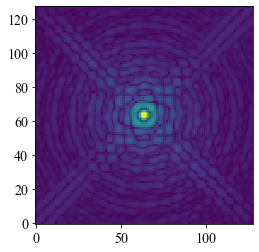

In [269]:
plt.imshow(psf.intensity**0.25)

In [270]:
otf_new = b._KPO__extract_cvis_ldft1(psf.intensity,b.M2PIX)
otf_new /= otf_new.max()

(250, 350)

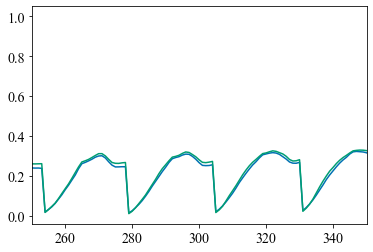

In [271]:
plt.plot(otf)
plt.plot(otf_new)
# plt.yscale('log')
plt.xlim(250,350)

In [272]:
objective = np.sum((otf-otf_new)**2)

In [273]:
objective

DeviceArray(0.27368674-8.60011e-09j, dtype=complex64)

In [274]:
from jax import grad

In [591]:
def make_osys(pupil):
    hst = morphine.ArrayOpticalElement(opd=np.zeros_like(pupil),
                                   transmission=np.array(pupil),
                                   pixelscale=ppscale,
                                   name='nicmos',planetype=1)
    hst.pupil_diam = pdiam
    

    osys = morphine.OpticalSystem(npix=pmask.shape[0])
    osys.add_pupil(hst)    
    osys.pupil_diameter = pdiam
    pscale = PIXSCALE
    osys.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=FOV)  # image plane coordinates in arcseconds
    osys.source_offset_r = 0*pscale
    osys.source_offset_theta = 0
    return osys
    
FF = np.array(b.FF)

def get_otf(osys):
    psf,intermediate = osys.propagate_mono(WAVELENGTH)
    otf_new = (FF.dot(psf.intensity.ravel()))
    otf_new /= np.abs(otf_new.max())
    return otf_new

def get_objective(osys):
    otf_new = get_otf(osys)
    return np.sum(np.abs(otf-otf_new)**2)

ur_pupil = np.zeros_like(pmask)
mask = np.isfinite(pmask)
mask = pmask>0
mask = (pmask>0)*(pmask<1)
mask = binary_dilation(mask,iterations=1)
flat = pmask==0
from scipy.ndimage import binary_dilation

def objective(pupil_values):
    pupil = index_update(ur_pupil,mask,pupil_values)
    osys = make_osys(pupil)
    return get_objective(osys)

In [592]:
objective(pmask[mask])

DeviceArray(36.243507, dtype=float32)

In [593]:
g = grad(objective)

In [594]:
g(dummy[mask])

DeviceArray([-0.0059573 , -0.01845649, -0.01975682, ..., -0.02626352,
             -0.01100829,  0.01632792], dtype=float32)

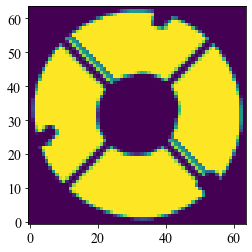

In [595]:
plt.imshow(pmask)

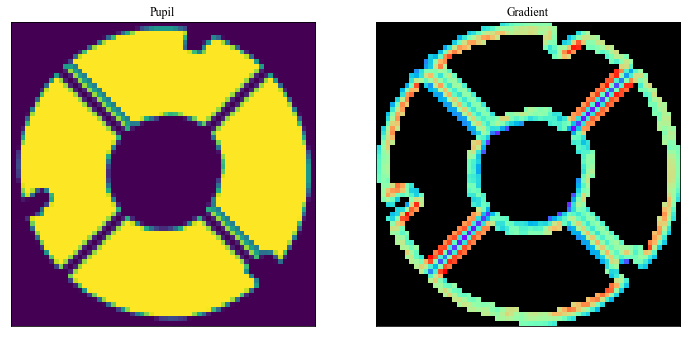

In [596]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12.0,6.0))
dummy = pmask.copy()

gg = np.zeros_like(dummy)

ax1.imshow(pmask)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Pupil')
gg = index_update(gg,mask,g(dummy[mask]))
gg = index_update(gg,~mask,np.nan)

ax2.imshow(gg.reshape(pmask.shape),cmap=phasemap)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Gradient')

plt.savefig('nicmos_gradient.png',bbox_inches='tight')

In [597]:
from scipy.optimize import minimize
def renormalize(thing):
    return (thing-np.nanmin(thing))/(np.nanmax(thing)-np.nanmin(thing))

In [598]:
# %%time
# optimal = minimize(objective, pmask.ravel(), jac=g, method='CG', options={'disp': True})

In [599]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

0 -26.17916 36.243507
40 -10.145192 33.02101
80 -10.235777 33.020638
120 -10.237333 33.020386
160 -10.237359 33.02038
200 -10.237363 33.02038
240 -10.237364 33.02038
280 -10.237362 33.02038
320 -10.237361 33.02037
360 -10.237358 33.020374


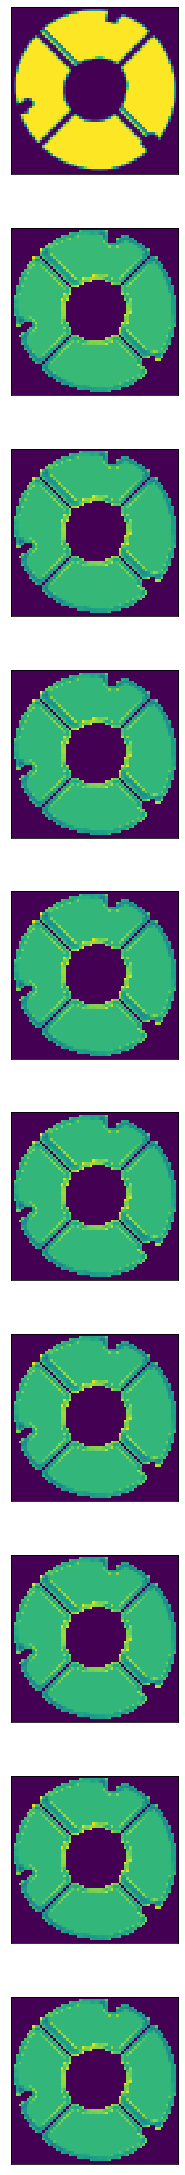

In [600]:
dummy = pmask.copy()
gg = np.zeros_like(dummy)
fig, axes = plt.subplots(10,1,figsize=(3,40))
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    
k=0
for j in range(400):
    gg = index_update(gg,mask,g(dummy[mask]))
    if j%40==0:
        print(j,gg.sum(),objective(dummy[mask]))
        axes[k].imshow(dummy)
        k+=1
    dummy -= gg #*(20-j/10+1)
    dummy = renormalize(dummy)
#     dummy = index_update(dummy,dummy<0, 0)
#     dummy = index_update(dummy,dummy>1, 1)
#     dummy /= dummy.max()
    dummy = index_update(dummy, flat, 0)
#     if gg.sum()<0:
#         break

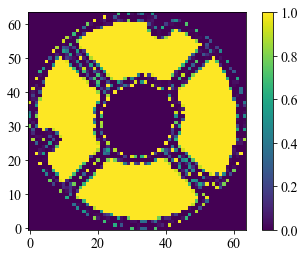

In [545]:
plt.imshow(dummy)
plt.colorbar()

In [405]:
objective(dummy[mask])

DeviceArray(17.32778, dtype=float32)

In [406]:
objective(pmask[mask])

DeviceArray(21.640072, dtype=float32)

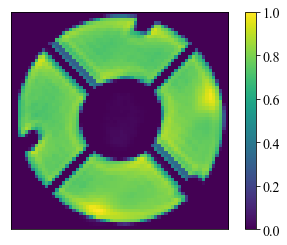

In [375]:
plt.imshow(dummy)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.savefig('nicmos_optimized.png',bbox_inches='tight')

In [362]:
new_otf = get_otf(make_osys(dummy))

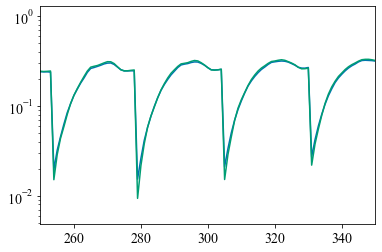

In [363]:
plt.plot(otf)
plt.plot(new_otf)
plt.xlim(250,350)
plt.yscale('log')

In [352]:
onp.savetxt('opt_F170M.txt',dummy)

In [364]:
PSZ     = 64   # size of the array for the model

oversample = 3
obstruction = 0.330
spiders = 0.011
m1 = 0.8921
m2 = (0.7555,-0.4615)
m3 = (-0.7606,-0.4564)
rout = 0.955
rin = 0.372
bigspiders = 0.0335
cpadr = 0.065
ppad = 0.8921
pad_theta1 = 121.
pad_theta2 = -121.5
shift = -0.08
ang = 45.

pmask  = HST_NIC1([obstruction,spiders,m1,m2,m3,rout,rin,bigspiders,
                  cpadr,ppad,pad_theta1,pad_theta2,shift,ang],PSZ,oversample=oversample) # rotated!
# pmask = np.roll(
#         np.roll(pmask, int(-0.0 * rad), axis=1),
#         int(0.08 * rad), axis=0) # MASK SHIFT !!

hst = morphine.ArrayOpticalElement(opd=np.zeros_like(pmask),
                               transmission=np.array(pmask),
                               pixelscale=ppscale,
                               name='nicmos',planetype=1)

rad = PSZ/2
pdiam   = 2.4 #*0.955 # telescope diameter in meters

ppscale = pdiam / (rad*2)


In [365]:
def objective_params(pupil_params):
    pupil = HST_NIC1(pupil_params,PSZ,oversample=3)
    osys = make_osys(pupil)
    return get_objective(osys)

nominal = [obstruction,spiders,m1,m2,m3,rout,rin,bigspiders,
                  cpadr,ppad,pad_theta1,pad_theta2,shift,ang]

In [366]:
h = grad(objective_params)

In [367]:
h(nominal)

Exception: Tracer can't be used with raw numpy functions. You might have
  import numpy as np
instead of
  import jax.numpy as np

In [ ]:
def rotate_coords(x, y, theta, ox, oy):
    """Rotate arrays of coordinates x and y by theta radians about the
    point (ox, oy).

    """
    s, c = np.sin(theta), np.cos(theta)
    x, y = np.asarray(x) - ox, np.asarray(y) - oy
    return x * c - y * s + ox, x * s + y * c + oy

def rotate_image(src, theta, ox, oy, fill=0):
    """Rotate the image src by theta degrees about (ox, oy).
    Pixels in the result that don't correspond to pixels in src are
    replaced by the value fill.

    """
    theta = theta*np.pi/180.
    # Images have origin at the top left, so negate the angle.
    theta = -theta

    # Dimensions of source image. Note that scipy.misc.imread loads
    # images in row-major order, so src.shape gives (height, width).
    sh, sw = src.shape

    # Rotated positions of the corners of the source image.
    cx, cy = rotate_coords([0, sw, sw, 0], [0, 0, sh, sh], theta, ox, oy)

    # Determine dimensions of destination image.
    dw, dh = (int(np.ceil(c.max() - c.min())) for c in (cx, cy))

    # Coordinates of pixels in destination image.
    dx, dy = np.meshgrid(np.arange(dw), np.arange(dh))

    # Corresponding coordinates in source image. Since we are
    # transforming dest-to-src here, the rotation is negated.
    sx, sy = rotate_coords(dx + cx.min(), dy + cy.min(), -theta, ox, oy)

    # Select nearest neighbour.
    sx, sy = sx.round().astype(int), sy.round().astype(int)

    # Mask for valid coordinates.
    mask = (0 <= sx) & (sx < sw) & (0 <= sy) & (sy < sh)

    # Create destination image.
    dest = np.empty(shape=(dh, dw), dtype=src.dtype)

    # Copy valid coordinates from source image.
    dest = index_update(dest,(dy[mask], dx[mask]),src[sy[mask], sx[mask]])
# #     dest[dy[mask], dx[mask]] = src[sy[mask], sx[mask]]

    # Fill invalid coordinates.
    dest = index_update(dest,(dy[~mask], dx[~mask]),fill)
#     dest[dy[~mask], dx[~mask]] = fill

    return dest


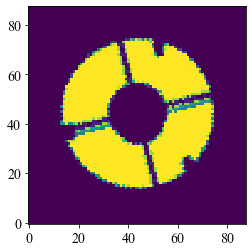

In [314]:
plt.imshow(rotate_image(pmask,121,pmask.shape[0],pmask.shape[1]))

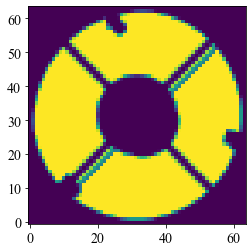

In [321]:
plt.imshow(rotate(pmask,90))